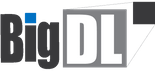

# Vision Transformer Examples for InferenceOptimizer

Today, vison Transformer is becoming more and more popular among computer vision community. On the one hand, people are constantly searching for larger pre-training corpus and pre-training model, on the other hand, how to land the vision transformer in the industrial scene is also a very concerned issue.

Here we take several popular vision Transformer architectures as examples to demonstrate how to use InferenceOptimizer in BigDL-Nano to accelerate inference pipeline.

##  step 0 : Prepare the environment
We recommend you to use [Anaconda](https://www.anaconda.com/distribution/#linux) to prepare the environment.

**Note**: during your installation, there may be some warnings or errors about version, just ignore them.
```bash
conda create -n nano python=3.7  # "nano" is conda environment name, you can use any name you like.
conda activate nano
pip install jsonargparse[signatures]
pip install --pre --upgrade bigdl-nano[pytorch]

# bf16 is available only on torch1.12
pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cpu 
# Necessary packages for inference accelaration
pip install --upgrade intel-extension-for-pytorch
pip install onnx==1.12.0 onnxruntime==1.12.1 onnxruntime-extensions
pip install openvino-dev
pip install neural-compressor==1.12
pip install --upgrade numpy==1.21.6
```

Initialize environment variables with script `bigdl-nano-init` installed with bigdl-nano, then unset environment variable `KMP_AFFINITY`.

```bash
source bigdl-nano-init
``` 

You may find environment variables set like follows:

```
conda dir found: /opt/anaconda3/envs/nano/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Setting LD_PRELOAD...
nano_vars.sh already exists
+++++ Env Variables +++++
LD_PRELOAD=/opt/anaconda3/envs/nano/bin/../lib/libiomp5.so /opt/anaconda3/envs/nano/lib/python3.7/site-packages/bigdl/nano//libs/libtcmalloc.so
MALLOC_CONF=
OMP_NUM_THREADS=112
KMP_AFFINITY=granularity=fine
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.
```

## step 1 : Prepare Dataset

As InferenceOptimizer needs validation data to calculate accuracy metric, we need to download [ImageNet validation dataset](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar) and [development kit](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz), and place them under directory `./img_data`.

Here we provide a helper function `create_imagenet_val_dataset` to help users create a subset of ImageNet validation dataset.

In [1]:
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, Subset
import torch
import numpy as np

def create_imagenet_val_dataset(limit_num_samples=None):
    dataset = ImageNet(root="img_data", split="val")
    if limit_num_samples is not None:
        indices = np.random.permutation(len(dataset))[:limit_num_samples]
        dataset = Subset(dataset, indices)
    return dataset

## step 2 : Import related package

[PyTorch Image Models (timm)](https://github.com/rwightman/pytorch-image-models) provides a collection of image models. Here we use some vision Transformer models with pre-trained weights provided by timm to demonstrate acceleration of InferenceOptimizer in BigDL-Nano. 

In [ ]:
from bigdl.nano.pytorch import InferenceOptimizer
import timm
from torchmetrics import Accuracy

## step 3 : Define dataloader, model then optimize
> 📝 **Note**
>
> Actually we highly recommand users pass real training dataloader to `training_data` for calibration of quantization. But as ImageNet training set is too large to download, we just use validation dataset as faked training dataset in blow cases.
> 
> If you want to get real performance on ImageNet validation set, you can just set `limit_num_samples=None`. Here we choose a subset to make inference pipeline faster and we just want to get a rough metric to evaluate the effect of quantization.

### 1. MobileViT

[MobileViT](https://arxiv.org/abs/2110.02178) is a light-weight, general-purpose, and mobile-friendly vision Transformer.

In [3]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                                       input_size=256,
                                       # in case we want to evaluate single sample latency, so set batch_size to 1
                                       batch_size=1,
                                       use_prefetcher=False,
                                       no_aug=True,
                                       crop_pct=0.9,
                                       interpolation="bicubic",
                                       mean=(0.0, 0.0, 0.0),
                                       std=(1.0, 1.0, 1.0),
                                       persistent_workers=False)
val_dataloader = create_loader(val_dataset,
                               input_size=256,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.0, 0.0, 0.0),
                               std=(1.0, 1.0, 1.0),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

#### Calculate latency using 1 thread

In [4]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

==========================Start Optimization==========================
----------Start test original model (1/13)----------
----------Finish test original model (1/13)----------
----------Start test fp32_ipex model (2/13)----------


2022-09-15 14:33:18,616 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmp1vtbbed7
2022-09-15 14:33:18,619 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmp1vtbbed7/_remote_module_non_scriptable.py
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/intel_extension_for_pytorch/frontend.py:262: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")


----------Finish test fp32_ipex model (2/13)----------
----------Start test bf16 model (3/13)----------


2022-09-15 14:33:21,055 - bigdl.nano.utils.log4Error - ERROR - 

****************************Usage Error************************
Your machine or OS doesn't support BF16 instructions.
2022-09-15 14:33:21,058 - bigdl.nano.utils.log4Error - ERROR - 

**************************How to fix***********************
Please check your machine and OS to make sure BF16 support is available.
2022-09-15 14:33:21,059 - bigdl.nano.utils.log4Error - ERROR - 

****************************Call Stack*************************


----------Start test bf16_ipex model (4/13)----------


/opt/anaconda3/envs/nano/lib/python3.7/site-packages/intel_extension_for_pytorch/frontend.py:262: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
[W LegacyTypeDispatch.h:74] Warning: AutoNonVariableTypeMode is deprecated and will be removed in 1.10 release. For kernel implementations please use AutoDispatchBelowADInplaceOrView instead, If you are looking for a user facing API to enable running your inference-only workload, please use c10::InferenceMode. Using AutoDispatchBelowADInplaceOrView in user code is under risk of producing silent wrong result in some edge cases. See Note [AutoDispatchBelowAutograd] for more details. (function operator())


----------Finish test bf16_ipex model (4/13)----------
----------Start test int8 model (5/13)----------
----------Finish test int8 model (5/13)----------
----------Start test jit_fp32 model (6/13)----------


/opt/anaconda3/envs/nano/lib/python3.7/site-packages/timm/models/mobilevit.py:296: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_h, new_w = math.ceil(H / patch_h) * patch_h, math.ceil(W / patch_w) * patch_w
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/timm/models/mobilevit.py:300: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if new_h != H or new_w != W:
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/timm/models/vision_transformer.py:201: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorc

----------Finish test jit_fp32 model (6/13)----------
----------Start test jit_fp32_ipex model (7/13)----------


/opt/anaconda3/envs/nano/lib/python3.7/site-packages/intel_extension_for_pytorch/frontend.py:262: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")


----------Finish test jit_fp32_ipex model (7/13)----------
----------Start test jit_fp32_ipex_channels_last model (8/13)----------
----------Finish test jit_fp32_ipex_channels_last model (8/13)----------
----------Start test openvino_fp32 model (9/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpq_3m4dvj/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpq_3m4dvj/tmp.bin
[ SUCCESS ] Total execution time: 0.77 seconds. 
[ SUCCESS ] Memory consumed: 119 MB. 
----------Finish test openvino_fp32 model (9/13)----------
----------Start test openvino_int8 model (10/13)----------


[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.6, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpf2wdmz62/tmp.xml
[ SUCCESS ] BIN file: /tmp/tmpf2wdmz62/tmp.bin
[ SUCCESS ] Total execution time: 0.77 seconds. 
[ SUCCESS ] Memory consumed: 119 MB. 
----------Finish test openvino_int8 model (10/13)----------
----------Start test onnxruntime_fp32 model (11/13)----------
----------Finish test onnxruntime_fp32 model (11/13)----------
----------Start test onnxruntime_int8_qlinear model (12/13)----------
----------Finish test onnxruntime_int8_qlinear model (12/13)----------
----------Start test onnxruntime_int8_integer model (13/13)----------


2022-09-15 14:36:12 [ERROR] Unexpected exception IndexError('list index (2) out of range') happened during tuning.
[ ERROR ]  Unexpected exception IndexError('list index (2) out of range') happened during tuning.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/experimental/quantization.py", line 148, in execute
    self.strategy.traverse()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/strategy/strategy.py", line 402, in traverse
    tune_cfg, self.model, self.calib_dataloader, self.q_func)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/utils/utility.py", line 262, in fi
    res = func(*args, **kwargs)
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/onnxrt.py", line 168, in quantize
    quantizer.quantize_model()
  File "/opt/anaconda3/envs/nano/lib/python3.7/site-packages/neural_compressor/adaptor/ox_utils/quantizer.py

Found no quantized model satisfying accuracy criterion.
----------Failed to convert to onnxruntime_int8_integer----------


==========================Optimization Results==========================
 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    24.861    |        0.666         |
|           fp32_ipex            |      successful      |    27.165    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |      successful      |   174.285    |        0.666         |
|              int8              |      successful      |    25.602    |        0.006         |
|            jit_fp32            |   

In [5]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    24.861    |        0.666         |
|           fp32_ipex            |      successful      |    27.165    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |      successful      |   174.285    |        0.666         |
|              int8              |      successful      |    25.602    |        0.006         |
|            jit_fp32            |      successful      |    20.241    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    19.565    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

#### calculate latency using 8 threads

In [ ]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=8)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

In [7]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    22.369    |        0.666         |
|           fp32_ipex            |      successful      |    28.957    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |      successful      |   275.438    |        0.666         |
|              int8              |      successful      |    21.016    |        0.006         |
|            jit_fp32            |      successful      |    24.59     |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    23.493    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

### 2. PoolFormer

[PoolFormer](https://arxiv.org/abs/2111.11418) verifys that the general architecture of the Transformers, instead of the specific token mixer module, is more essential to the model's performance.

In [9]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

#### calculate latency using 1 thread

In [ ]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

In [11]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    49.279    |        0.809         |
|           fp32_ipex            |      successful      |    51.137    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   939.142    |         None         |
|              int8              |   fail to convert    |     None     |         None         |
|            jit_fp32            |    early stopped     |   446.137    |         None         |
|         jit_fp32_ipex          |    early stopped     |   459.504    |         None         |
|  jit_fp32_ipex_channels_last   |    earl

#### calculate latency using 4 threads

In [ ]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=4)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)

In [13]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    26.259    |        0.809         |
|           fp32_ipex            |      successful      |    25.588    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   460.863    |         None         |
|              int8              |   fail to convert    |     None     |         None         |
|            jit_fp32            |    early stopped     |   438.965    |         None         |
|         jit_fp32_ipex          |    early stopped     |   445.075    |         None         |
|  jit_fp32_ipex_channels_last   |    earl

### 3. Swin Transformer

[Swin Transformer](https://arxiv.org/abs/2103.14030) proposes hierarchical vision Transformer using shifted windows.

> ⚠️ **Warning**
>
> Swin don't support dynamic batch, so the batch_size of faked_train_dataloader must be the same with val_dataloader.
>
> Otherwise the accuracy will be very low.

In [14]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
val_dataset = create_imagenet_val_dataset(limit_num_samples=20)
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

#### calculate latency using 1 thread

In [ ]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

In [16]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |   297.599    |         0.8          |
|           fp32_ipex            |      successful      |   303.915    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |      successful      |   665.498    |         0.8          |
|              int8              |      successful      |   181.373    |         0.85         |
|            jit_fp32            |      successful      |   270.696    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    287.27    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

#### calculate latency using 8 threads

In [ ]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=8)
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("best option is ", option)
# print(acc_model(next(iter(val_dataloader))[0]).argmax())

In [18]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    96.791    |         0.8          |
|           fp32_ipex            |      successful      |    95.871    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   903.938    |         None         |
|              int8              |      successful      |    86.094    |         0.85         |
|            jit_fp32            |      successful      |    81.166    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |     80.6     |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su